## Data Science Projekt - Fruitdata

##### In dieser Analyse wird die Excel-Datei 'fruit_data' verwendet, die Daten zu drei verschiedenen Fruchtsorten enthält. 
##### Die Forschungsfrage lautet: Wie kann ein Klassifikator entwickelt werden, der zwischen Bananen, Trauben und Äpfeln unterscheiden kann? 
##### Das Ziel des Projekts ist es, einen solchen Klassifikator zu entwickeln. Dazu werden zwei maschinelle Lernmodelle eingesetzt: die logistische Regression und der Entscheidungsbaum.

### Imports

In [1]:
# Importierung der Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

### Einlesen der Excel-Datei

In [2]:
# Einlesen der Excel-Datei
data = pd.read_excel('fruit_data.xlsx')

# Ausgabe der ersten 10 Zeilen der Daten
print(data.head(10))


   Unnamed: 0 fruit_type         color    size     weight
0           0      grape        Yellow    Tiny   8.303385
1           1      apple          Pink  Largee  80.976370
2           2     banana   Pale Yellow   Large  74.615192
3           3      grape           Red    Tiny   6.924070
4           4     banana  Creamy White  Largee  82.002542
5           5     banana         Green   Large  89.719116
6           6      apple         Green  Largee  72.036243
7           7      grape         Green   Small   5.371310
8           8      apple          Pink  Largee  87.272178
9           9      grape           Red   Small   7.409021


In [3]:
# Ausgabe der Datentypen der Spalten

print(data.dtypes)

Unnamed: 0      int64
fruit_type     object
color          object
size           object
weight        float64
dtype: object


In [4]:
# Ausgabe der Beschreibung der nummerischen Daten

print(data.describe())

       Unnamed: 0      weight
count  200.000000  200.000000
mean    99.500000   59.047220
std     57.879185   46.697739
min      0.000000    1.000000
25%     49.750000    8.142752
50%     99.500000   63.109415
75%    149.250000   94.367815
max    199.000000  250.000000


### Daten bereinigung

#### Die Spalte 'Unnamed: 0' wird entfernt, da sie lediglich die Zeilenindizes enthält und für die Analyse nicht relevant ist.

In [5]:
# Entfernen der Spalte 'Unnamed: 0'
data = data.drop('Unnamed: 0', axis=1)

# Ausgabe der ersten 10 Zeilen der Daten, um die Entfernung der Spalte zu überprüfen
print(data.head(10))

  fruit_type         color    size     weight
0      grape        Yellow    Tiny   8.303385
1      apple          Pink  Largee  80.976370
2     banana   Pale Yellow   Large  74.615192
3      grape           Red    Tiny   6.924070
4     banana  Creamy White  Largee  82.002542
5     banana         Green   Large  89.719116
6      apple         Green  Largee  72.036243
7      grape         Green   Small   5.371310
8      apple          Pink  Largee  87.272178
9      grape           Red   Small   7.409021


#### Anschließend werden die Werte der jeweiligen Spalten ausgegeben, um nach möglichen Datenfehlern und fehlenden Werten zu suchen.

In [6]:
# Ausgabe der Werte der Spalte 'fruit_name'
unique_type = data['fruit_type'].unique()

# Ausgabe der Werte der Spalte 'fruit_name'
print(unique_type)

['grape' 'apple' 'banana']


In [7]:
# Ausgabe der Werte der Spalte 'color'
unique_colors = data['color'].unique()

# Ausgabe der Werte der Spalte 'color'
print(unique_colors)

['Yellow' 'Pink' 'Pale Yellow' 'Red' 'Creamy White' 'Green' 'Yellow1'
 'Purple' 'Black']


#### Wie oben in der Ausgabe zu erkennen ist, befindet sich in der Spalte 'color' ein Datenfehler: 'Yellow1'.

In [8]:
# Ausgabe der Werte der Spalte 'size'
unique_sizes = data['size'].unique()

# Ausgabe der Werte der Spalte 'size'
print(unique_sizes)


['Tiny' 'Largee' 'Large' 'Small' 'Medium']


In [9]:
# Korrigierung des Tippfehlers in der 'size'-Spalte
data['size'] = data['size'].replace({'Largee': 'Large'})

# Korrigierung des Tippfehlers in der 'color'-Spalte
data['color'] = data['color'].replace({'Yellow1': 'Yellow'})

#  Überpürfung
print(data['size'].unique())
print(data['color'].unique())


['Tiny' 'Large' 'Small' 'Medium']
['Yellow' 'Pink' 'Pale Yellow' 'Red' 'Creamy White' 'Green' 'Purple'
 'Black']


### Datenvisualisierung

#### Zur Erkennung von Ausreißern wird ein Boxplot erstellt, der auf der Y-Achse die Spalte 'weight' verwendet, da sie eine numerische Variable darstellt. Die X-Achse zeigt die 'fruit_type'-Spalte, um einen direkten Vergleich zwischen den verschiedenen Fruchtsorten zu ermöglichen.

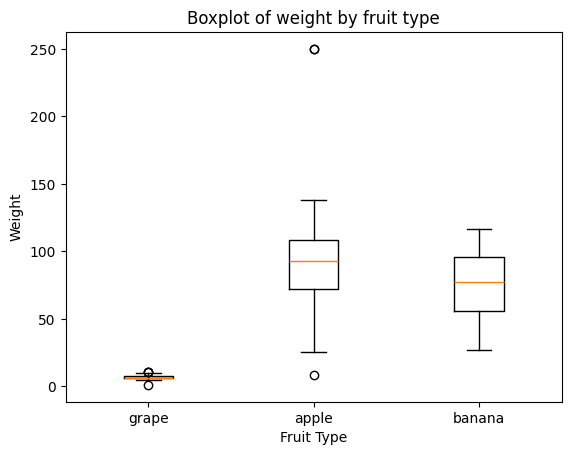

In [10]:
# Erstellung eines Boxplots der Gewichte nach Fruchttyp
plt.boxplot([data[data['fruit_type'] == 'grape']['weight'],
             data[data['fruit_type'] == 'apple']['weight'],
             data[data['fruit_type'] == 'banana']['weight']],
            labels=['grape', 'apple', 'banana'])

plt.xlabel('Fruit Type')
plt.ylabel('Weight')
plt.title('Boxplot of weight by fruit type')
plt.show()

#### Trauben (Grapes): Das Gewicht der Trauben ist im Vergleich zu Äpfeln und Bananen deutlich geringer, wie klar zu erkennen ist. Es gibt einige Ausreißer, die durch Punkte oberhalb der oberen Whisker des Boxplots dargestellt werden, sowie unterhalb des unteren Whiskers.

#### Äpfel (Apples): Die Gewichte der Äpfel variieren um etwa 100 Einheiten. Ein deutlicher Ausreißer liegt bei etwas über 250 Einheiten. Ein weiterer Ausreißer unterhalb des Boxplots ist ebenfalls vorhanden, liegt jedoch näher an den restlichen Datenpunkten und weicht weniger stark vom Median und den anderen Werten ab.

#### Bananen (Bananas): Die Gewichtsverteilung der Bananen ist breit gestreut, wobei der Median etwas niedriger liegt als bei den Äpfeln. Es gibt keine auffälligen Ausreißer.

In [11]:
# Ausreißer für jede Fruchtart identifizieren
def identify_outliers(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Definieren der Ausreißer für jede Fruchtart
outliers_grape = identify_outliers(data[data['fruit_type'] == 'grape'], 'weight')
outliers_apple = identify_outliers(data[data['fruit_type'] == 'apple'], 'weight')
outliers_banana = identify_outliers(data[data['fruit_type'] == 'banana'], 'weight')

# Ausgabe der Anzahl der Ausreißer für jede Fruchtart
print('Ausreißer Trauben:', outliers_grape)
print('Ausreißer Äpfel:', outliers_apple)
print('Ausreißer Bananen:', outliers_banana)


Ausreißer Trauben:     fruit_type   color    size     weight
34       grape  Purple    Tiny  10.902198
37       grape  Yellow    Tiny   1.000000
138      grape   Green   Small  10.902198
192      grape   Green  Medium  10.902198
Ausreißer Äpfel:     fruit_type   color    size      weight
26       apple   Green   Small  250.000000
33       apple  Yellow  Medium  250.000000
175      apple   Green  Medium    8.300753
Ausreißer Bananen: Empty DataFrame
Columns: [fruit_type, color, size, weight]
Index: []


In [12]:
# Entfernen der Ausreißer
data = data.drop(outliers_grape.index)
data = data.drop(outliers_apple.index)

# Überprüfung der Anzahl der Datensätze nach Entfernung der Ausreißer
print(data.shape)

(193, 4)


### Modellierung und Analyse

#### Logistische Regression

#### Bevor die logistische Regression entwickelt wird, müssen die kategorialen Variablen in numerische Variablen umgewandelt werden. Dies geschieht durch One-Hot-Encoding, bei dem beispielsweise die Kategorie 'Yellow' in eine binäre Variable '1' umgewandelt wird. Da das Modell nur numerische Werte verarbeiten kann, ist dieser Schritt notwendig. Anschließend wird die Zielvariable definiert, auf die unsere Merkmale prognostizieren sollen. Der Datensatz wird dann in Trainings- und Testdatensätze aufgeteilt: Der Trainingsdatensatz dient zur Modellentwicklung, während der Testdatensatz zur Evaluierung der Modellleistung verwendet wird. Die Standardisierung ist erforderlich, um sicherzustellen, dass alle numerischen Variablen denselben Maßstab haben und das Modell nicht durch unterschiedlich skalierte Merkmale verzerrt wird. Schließlich wird die logistische Regression erstellt.

In [13]:
# One-Hot-Encoding, um kategorische Variablen in numerische umzuwandeln
data_encoded = pd.get_dummies(data, columns=['color', 'size'], drop_first=True)

# Merkmale (X) und Zielvariable (y) definieren
X = data_encoded.drop(columns=['fruit_type'])
y = data_encoded['fruit_type']

# Training und Testdatensatz aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisierung der Merkmale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modell erstellen und trainieren
model = LogisticRegression(multi_class='ovr', solver='liblinear')
model.fit(X_train_scaled, y_train)

# Vorhersagen auf Testdatensatz
y_pred = model.predict(X_test)

# Binarisieren der Zielvariablen für ROC-AUC
y_test_bin = label_binarize(y_test, classes=model.classes_)
y_pred_proba = model.predict_proba(X_test_scaled)

# Modellbewertung
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')

# Ausgabe der Modellbewertung
print('Accuracy: ', accuracy)
print('F1-Score: ', f1)
print('ROC-AUC: ', roc_auc)



Accuracy:  0.3333333333333333
F1-Score:  0.16666666666666666
ROC-AUC:  0.9546351084812624


/Users/tunahansari/.pyenv/versions/3.9.18/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


#### Interpretation:

#### Accuracy: Das Modell klassifiziert etwa 33% der Testdaten korrekt. Dies ist ein relativ niedriger Wert.

#### F1-Score: Der F1-Score ist noch niedriger als die Accuracy und deutet darauf hin, dass das Modell erhebliche Schwierigkeiten hat und stark unterperformt.

#### ROC-AUC: Der ROC-AUC Wert ist überraschend hoch, was darauf hindeutet, dass das Modell eine gute Fähigkeit zur Unterscheidung zwischen den Klassen besitzt, wenn es um die Wahrscheinlichkeiten geht.

#### Es könnte auf ein schlecht balanciertes Modell hinweisen, das schlecht kalibriert ist -> Lösung: Verwendung von Hyperparameter, um die Balance zwischen den Klassen zu verbessern und die Modellleistung insgesamt zu steigern.

### Hyperparameter für die logistische Regression

#### Hyperparameter werden zur Optimierung der logistischen Regression verwendet. In diesem Fall nutzen wir GridSearchCV, um die besten Hyperparameter für die logistische Regression zu ermitteln. Verschiedene Solver ('lbfgs', 'newton-cg', 'sag', 'saga') werden ausgewählt, da sie besonders gut für Multiklassen-Probleme geeignet sind. Der Regularisierungsparameter 'C' steuert die Modellkomplexität, wobei kleinere Werte eine stärkere Regularisierung bewirken. Der Parameter 'multi_class' legt fest, wie das Modell Multiklassen-Probleme behandelt. Durch diese Hyperparameter wird sichergestellt, dass das Modell mit den optimalen Einstellungen die beste Leistung in Bezug auf Accuracy, F1-Score und ROC-AUC.

In [14]:
# Hyperparameter-Raster für logistische Regression
param_grid_lr = {
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
    'C': [0.01, 0.1, 1, 10],
    'multi_class': ['ovr', 'multinomial']
}

# Grid-Suche für logistische Regression
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train_scaled, y_train)

# Bestes Modell und Hyperparameter
best_lr_model = grid_search_lr.best_estimator_
print(f'Beste Hyperparameter für die logistische Regression: {grid_search_lr.best_params_}')

# Modellbewertung
y_pred_lr = best_lr_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
roc_auc_lr = roc_auc_score(label_binarize(y_test, classes=best_lr_model.classes_), best_lr_model.predict_proba(X_test_scaled), average='weighted', multi_class='ovr')

print('Accuracy: ', accuracy_lr)
print('F1-Score: ', f1_lr)
print('ROC-AUC: ', roc_auc_lr)



Beste Hyperparameter für die logistische Regression: {'C': 10, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Accuracy:  0.8205128205128205
F1-Score:  0.8085924195981122
ROC-AUC:  0.9591434206818823


#### Interpretation:

#### Accuracy: Das Modell klassifiziert etwa 82% der Testdaten korrekt, was auf eine solide Leistung hinweist.

#### F1-Score: Der F1-Score liegt bei etwa 80.86%, was auf ein gutes Gleichgewicht zwischen Präzision und Recall hindeutet.

#### ROC-AUC: Der ROC-AUC-Wert von 95.91% zeigt eine ausgezeichnete Fähigkeit des Modells zur Unterscheidung zwischen den Klassen.

#### Insgesamt ist das Modell gut optimiert und liefert starke Ergebnisse, sodass keine wesentlichen Anpassungen mehr erforderlich sind.

### Entscheidungsbaum


#### Auch hier werden die Daten vorbereitet. Die Standardisierung der Merkmale ist für Entscheidungsbäume zwar optional, wird jedoch durchgeführt, um sicherzustellen, dass alle numerischen Variablen denselben Maßstab haben. Anschließend wird der Entscheidungsbaum erstellt und trainiert.

In [15]:
# One-Hot-Encoding für kategorische Variablen
data_encoded = pd.get_dummies(data, columns=['color', 'size'], drop_first=True)

# Merkmale (X) und Zielvariable (y) definieren
X = data_encoded.drop(columns=['fruit_type'])
y = data_encoded['fruit_type']

# Training und Testdatensatz aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisierung der Merkmale (optional für Entscheidungsbaum)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entscheidungsbaum erstellen und trainieren
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_scaled, y_train)

# Vorhersagen auf Testdatensatz
y_pred = tree_model.predict(X_test_scaled)

# Binarisieren der Zielvariablen für ROC-AUC
y_test_bin = label_binarize(y_test, classes=tree_model.classes_)
y_pred_proba = tree_model.predict_proba(X_test_scaled)

# Modellbewertung
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')

# Ausgabe der Modellbewertung
print('Accuracy: ', accuracy)
print('F1-Score: ', f1)
print('ROC-AUC: ', roc_auc)


Accuracy:  0.8717948717948718
F1-Score:  0.8683047140397412
ROC-AUC:  0.9052197802197802


#### Interpretation:

#### Accuracy: Das Modell klassifiziert etwa 87% der Testdaten korrekt, was auf eine sehr gute Leistung hinweist.

#### F1-Score: Der F1-Score liegt bei etwa 86.84% und zeigt, dass das Modell ein gutes Gleichgewicht zwischen Präzision und Recall erreicht hat.

#### ROC-AUC: Der ROC-AUC-Wert von 90.52% deutet darauf hin, dass der Entscheidungsbaum eine ausgezeichnete Fähigkeit zur Unterscheidung zwischen den Klassen besitzt.

#### Insgesamt zeigt der Entscheidungsbaum eine starke Leistung und ist gut geeignet für die Klassifikation der Fruchtsorten.

### Hyperparameter für den Entscheidungsbaum

In [16]:
# Hyperparameter-Raster für Entscheidungsbaum
param_grid_tree = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'sqrt', 'log2']
}

# Grid-Suche für Entscheidungsbaum
grid_search_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_tree, cv=5, scoring='accuracy')
grid_search_tree.fit(X_train_scaled, y_train)

# Bestes Modell und Hyperparameter
best_tree_model = grid_search_tree.best_estimator_
print(f'Beste Hyperparameter für Entscheidungsbaum: {grid_search_tree.best_params_}')

# Modellbewertung
y_pred_tree = best_tree_model.predict(X_test_scaled)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree, average='weighted')
roc_auc_tree = roc_auc_score(label_binarize(y_test, classes=best_tree_model.classes_), best_tree_model.predict_proba(X_test_scaled), average='weighted', multi_class='ovr')

# Ausgabe der Modellbewertung
print('Accuracy: ', accuracy_tree)
print('F1-Score: ', f1_tree)
print('ROC-AUC: ', roc_auc_tree)


Beste Hyperparameter für Entscheidungsbaum: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1}
Accuracy:  0.8717948717948718
F1-Score:  0.8683047140397412
ROC-AUC:  0.9158918005071851


#### Interpretation:

#### Accuracy: Das Modell klassifiziert etwa 87.18% der Testdaten korrekt, was auf eine sehr gute Leistung hinweist.

#### F1-Score: Der F1-Score liegt bei etwa 86.38%, was auf ein ausgewogenes Verhältnis zwischen Präzision und Recall hindeutet.

#### ROC-AUC: Der ROC-AUC-Wert von 91.59% zeigt, dass der Entscheidungsbaum eine ausgezeichnete Fähigkeit zur Unterscheidung zwischen den Klassen besitzt.

#### Insgesamt zeigt der optimierte Entscheidungsbaum eine starke und konsistente Leistung, die durch die gezielte Anpassung der Hyperparameter noch weiter verbessert wurde.